In [1]:
import torch
import torch.nn as nn

In [4]:
import os
from PIL import Image
import natsort 

class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc)#.convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
import torchvision.transforms as transforms 
image_encoding_path = "/home/jlw2247/DT/depthEncodingData/"
transform = transforms.ToTensor()

image_dataset = CustomDataSet(image_encoding_path, transform)
train_imgs, val_imgs = torch.utils.data.random_split(image_dataset, [3000, 473])

train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=256, num_workers=0)
test_loader =  torch.utils.data.DataLoader(val_imgs, batch_size=1, num_workers=0)

In [5]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(27 * 27 * 32, 128),
            # nn.Linear(23328,128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 27 * 27 * 32),
            # nn.Linear(128,23328),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 27, 27))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            # nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [6]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=23328, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 27, 27))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [7]:
from tqdm.notebook import tqdm

def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in tqdm(dataloader): # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        # image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_batch
        image_noisy = image_noisy.cuda()   
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [8]:
import numpy as np

epochs = 50
loss_log = []

for epoch in range(epochs):
    epoch_loss = train_epoch_den(encoder, decoder, 'cpu', train_loader, loss_fn, optim)
    print("Epoch %d: loss = %f" %(epoch+1, epoch_loss))
    loss_log.append(epoch_loss)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1: loss = 0.010122


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2: loss = 0.005651


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3: loss = 0.003388


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4: loss = 0.002312


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5: loss = 0.001700


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6: loss = 0.001275


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7: loss = 0.001014


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8: loss = 0.000828


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9: loss = 0.000715


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10: loss = 0.000638


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11: loss = 0.000576


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12: loss = 0.000539


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13: loss = 0.000495


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14: loss = 0.000463


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15: loss = 0.000474


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16: loss = 0.000414


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17: loss = 0.000378


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18: loss = 0.000373


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19: loss = 0.000345


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20: loss = 0.000331


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21: loss = 0.000319


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 22: loss = 0.000302


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 23: loss = 0.000295


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 24: loss = 0.000287


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 25: loss = 0.000286


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 26: loss = 0.000275


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 27: loss = 0.000272


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 28: loss = 0.000269


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 29: loss = 0.000267


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 30: loss = 0.000266


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 31: loss = 0.000261


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 32: loss = 0.000260


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 33: loss = 0.000257


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 34: loss = 0.000255


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 35: loss = 0.000256


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 36: loss = 0.000251


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 37: loss = 0.000251


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 38: loss = 0.000247


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 39: loss = 0.000248


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 40: loss = 0.000244


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 41: loss = 0.000248


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 42: loss = 0.000243


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 43: loss = 0.000241


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 44: loss = 0.000240


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 45: loss = 0.000240


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 46: loss = 0.000239


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 47: loss = 0.000236


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 48: loss = 0.000238


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 49: loss = 0.000236


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 50: loss = 0.000236


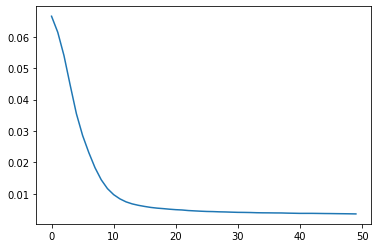

In [28]:
import matplotlib.pyplot as plt

plt.plot(loss_log)

In [41]:
encoded.shape

torch.Size([1, 32])

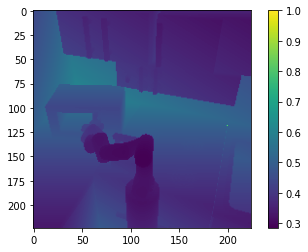

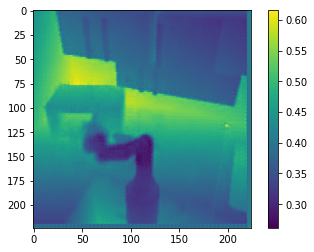

In [15]:
import matplotlib.pyplot as plt

sample_img = iter(test_loader).next()

encoded = encoder(sample_img.cuda())
decoded = decoder(encoded)

K = 0

input_sample = sample_img[K].numpy().transpose(1,2,0)
decoded_sample = decoded[K].detach().cpu().numpy().transpose(1,2,0)

plt.figure()
plt.imshow(input_sample)
plt.colorbar()
plt.figure()
plt.imshow(decoded_sample)
plt.colorbar()

In [17]:
torch.save(encoder.state_dict(), "encoder_depth.pth")
torch.save(decoder.state_dict(), "decoder_depth.pth")